In [1]:
using Compat, Random, Distributions, Plots, LinearAlgebra, CSV, DataFrames, SpecialFunctions, Statistics, NLsolve, Optim, KernelDensity, LaTeXStrings
gr(fmt=:png)
Random.seed!(1);

In [2]:
function norm_den(x)
    return 1/sqrt(2*π*s^2)*exp(-(x-m)^2/2/s^2)
end

function gap(x, g)
    F = zeros(4)
    a1 = abs(x[1])
    a2 = abs(x[2])
    b = abs(x[3])
    w = min(abs(x[4]),1)
    F[1] = g[1] - (w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)/(w*a1 + b*(1-w)*a2)^2
    F[2] = g[2] - (w*a1*(a1+1)*(a1+2)+b^3*(1-w)*(a2+2)*(a2+1)*a2)/(w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)/(w*a1 + b*(1-w)*a2)
    F[3] = g[3] - (w*a1*(a1+1)*(a1+2)*(a1+3)+b^4*(1-w)*(a2+3)*(a2+2)*(a2+1)*a2)/(w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)^2
    F[4] = g[4] - (w*a1*(a1+1)*(a1+2)*(a1+3)*(a1+4) + b^5*(1-w)*(a2+4)*(a2+3)*(a2+2)*(a2+1)*a2)/(w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)/(w*a1*(a1+1)*(a1+2) + b^3*(1-w)*(a2+2)*(a2+1)*a2)
    return sum(F.*F)
end

gap (generic function with 1 method)

In [3]:
# read the file

# instead of df = CSV.read("usa1.csv"); --- old way of reading a CSV into a dataframe; REPLACE WITH THE LINE BELOW
df = CSV.read("usa1.csv", DataFrame);

In [4]:
# fill the missing

count, L = 0, size(df,1)
new_prices = zeros(L)
for i in df.id
    count = count + 1
    if count < L
        if isa(df.miss[count+1],Number) & !isa(df.miss[count],Number) & (df.id[count] == df.id[count+1])
            j = count + 1
            while (df.id[j] == df.id[count]) & isa.(df.miss[j],Number)
                j = j + 1
            end
            if (df.id[j] == df.id[count])
                for k in count:1:j
                    if k < (count+j)/2+1
                        new_prices[k] = df.price[count]
                        else
                            new_prices[k] = df.price[j]
                        end
                end     
                else
                    for k in count:1:j-1
                        new_prices[k] = df.price[count]
                    end
                end        
        end
    end
end
new_prices[isa.(df.price,Number)] = df.price[isa.(df.price,Number)];

In [5]:
#initiate the spells database

spell_price = []
spell_url = []
spell_duration = []
spell_id = []
spell_category = []
spell_sale = []
spell_initial = []
spell_final = []
duration = 0
init = 0
fin = 0

for i in 1:1:L-1
    duration = duration + 1
    if isa(df.initialspell[i],Number)
        init = 1
    end
    if isa(df.lastspell[i],Number)
        fin = 1
    end
    if (df.id[i+1] != df.id[i]) || (new_prices[i+1] != new_prices[i])
        append!(spell_price,new_prices[i])
        append!(spell_id,df.id[i])
        append!(spell_url,df.cat_url[i])
        append!(spell_duration,duration)
        append!(spell_category,df.category[i])
        append!(spell_initial,init)
        append!(spell_final,fin)
        if isa(df.sale[i],Number)
            append!(spell_sale,df.sale[i])
        else
            append!(spell_sale,0)                
        end
        duration = 0
        init = 0
        fin = 0
    end
end

In [6]:
# write the new dataframe

dfspells = DataFrame(id = spell_id, url = spell_url, category = spell_category, price = spell_price, duration = spell_duration, initial = spell_initial, final = spell_final, sale = spell_sale)
dfspells.change = zeros(size(dfspells,1))
dfspells.logchange = zeros(size(dfspells,1))
upper_cutoff = 1.5
lower_cutoff = 0.009
remove_sales, remove_short = false, false

# replace the sales, small and large deviations, and short spells with the previous price

flag = [0, 0, 0, 0, 0]
N = length(dfspells.id)
for i in 1:1:N-1
    if (remove_sales) & (dfspells.sale[i+1] == 1)
        dfspells.price[i+1] = dfspells.price[i]
        flag[1] += 1
    end
    if (remove_short) & (dfspells.id[i] == dfspells.id[i+1]) & (dfspells.duration[i+1] < 3)
        dfspells.price[i+1] = dfspells.price[i]
        flag[2] += 1
    end
    if (abs(dfspells.price[i+1] - dfspells.price[i]) < lower_cutoff) & (dfspells.id[i] == dfspells.id[i+1])
        if abs(dfspells.price[i+1] - dfspells.price[i]) > 0
            flag[3] += 1
        end
        dfspells.price[i+1] = dfspells.price[i]
    end
    if (dfspells.id[i] == dfspells.id[i+1]) & (abs(log(dfspells.price[i+1]) - log(dfspells.price[i])) > upper_cutoff)
        dfspells.price[i+1] = dfspells.price[i]
        flag[4] += 1
    end
end
print("Sales deleted: ",flag[1],"\nShort spells deleted: ",flag[2],"\nSmall changes deleted: ",flag[3],"\nLarge changes deleted: ",flag[4])

# merge neighboring spells with the same price and id

for i in 1:1:N-1
    if (abs(dfspells.price[i] - dfspells.price[i+1]) < lower_cutoff) & (dfspells.id[i] == dfspells.id[i+1])
        dfspells.duration[i+1] = dfspells.duration[i+1] + dfspells.duration[i]
        dfspells.initial[i+1] = dfspells.initial[i]
        dfspells.duration[i] = 0
    end
end

# delete zero durations and add changes

dfspells = dfspells[dfspells.duration .> 0, :]
dfspells = dfspells[dfspells.initial.*dfspells.final .== 0, :]
N = length(dfspells.id)
for i in 1:1:N-1
    if dfspells.initial[i+1] == 0
        dfspells.change[i+1] = (dfspells.price[i+1]-dfspells.price[i])/dfspells.price[i]
        dfspells.logchange[i+1] = log(dfspells.price[i+1])-log(dfspells.price[i])
    end
end
select!(dfspells, Not(:sale))
dfspells.length = dfspells.initial - dfspells.final

# go forwards and write the spell number

count = 0
for i in 1:1:N
    count = count + 1
    dfspells.initial[i] = count
    if dfspells.final[i] == 1
        count = 0
    end
end

# go backwards and write the spell length

num = 0
for i in 1:1:N
    if dfspells.final[N+1-i] == 1
        num = dfspells.initial[N+1-i]
    end
    dfspells.length[N+1-i] = num
end

# three products have confcting category identificators, delete them

dfspells = dfspells[dfspells.id .!= 41976, :]
dfspells = dfspells[dfspells.id .!= 46568, :]
dfspells = dfspells[dfspells.id .!= 45549, :];

# write the file with spells

CSV.write("spells1.csv",dfspells);

Sales deleted: 0
Short spells deleted: 0
Small changes deleted: 0
Large changes deleted: 87

In [7]:
# take products with at least 3 spells (equivalently, at least two changes)

df2 = dfspells[dfspells.length .> 2, :]
S = size(df2[df2.initial .== 3, :],1)
pow41 = (df2[df2.initial .== 2, :].logchange).^4
pow21 = (df2[df2.initial .== 2, :].logchange).^2
pow22 = (df2[df2.initial .== 3, :].logchange).^2;

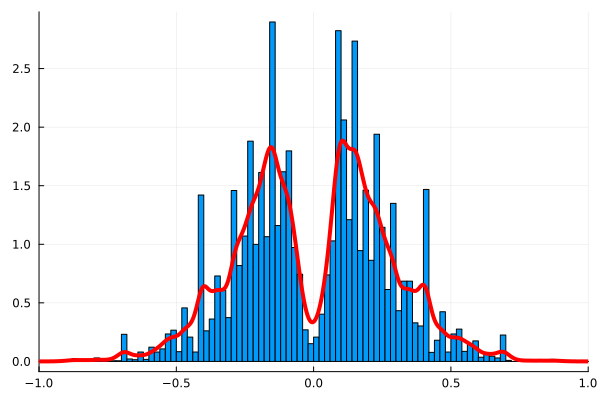

In [8]:
# histogram for an example category

df561 = dfspells[dfspells.category .== 561, :]
density = kde(df561[df561.logchange .!= 0.0, :].logchange,bandwidth=0.03,kernel=Logistic)
histogram(df561[df561.logchange .!= 0.0, :].logchange,xlim=[-1.0,1.0],bins=200,legend=false,normed=true)
plot!(density.x,density.density,color=:red,linewidth=4)

In [9]:
CSV.write("561.csv",df561[df561.logchange .!= 0.0, :])

"561.csv"

mean absolute price change 0.22689574071501514;
 standard deviation of absolute price change 0.14301799817841288

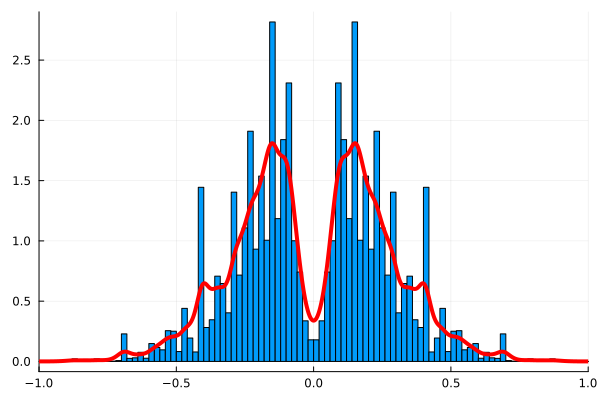

In [10]:
# symmetrized histogram and fitted kernel density

changes = [df561[df561.logchange .!= 0.0, :].logchange; -df561[df561.logchange .!= 0.0, :].logchange]
density = kde(changes,bandwidth=0.03,kernel=Logistic)
kernel_den = DataFrame(x = density.x, q = density.density)
CSV.write("kernel_den.csv",kernel_den)
print("mean absolute price change ",mean(abs.(changes)),";\n standard deviation of absolute price change ",std(abs.(changes)))
histogram(changes,xlim=[-1.0,1.0],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

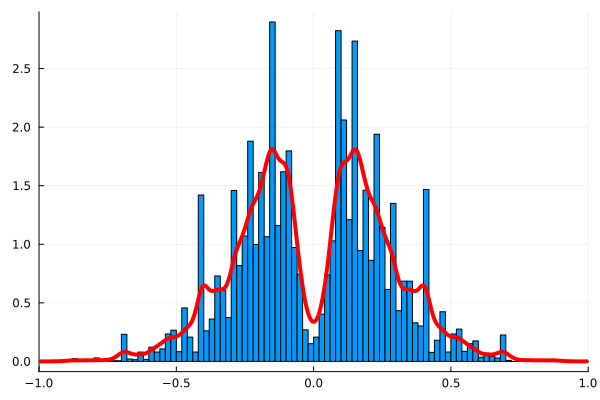

In [11]:
histogram(df561[df561.logchange .!= 0.0, :].logchange,xlim=[-1.0,1.0],bins=200,legend=false,normed=true)
plot!(density.x,density.density,color=:red,linewidth=4)

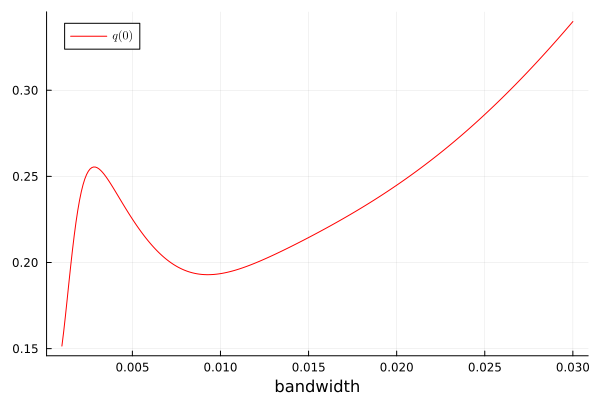

In [12]:
# plot q(0) as a function of bandwidth

BW, q0 = collect(0.001:0.0001:0.03), []
for bw in BW
    dens = kde(changes,bandwidth=bw)
    append!(q0,(dens.density[Int64(length(dens.density)/2)+1]+dens.density[Int64(length(dens.density)/2)])/2)
end
plot(BW,q0,label=L"q(0)",legend=:topleft,color=:red,xlabel="bandwidth")


Underlying: 1.2661647163458019 (0.039851827401848255)
Pooled: 3.6309735168437243 (0.1163704976909812)


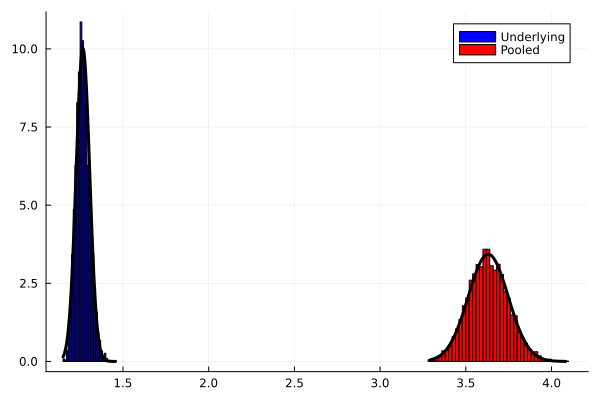

In [13]:
# bootstrapping procedure to see the difference between the pooled kurtosis 
# and the underlying kusrtosis estimated with the first two price changes

b, B, K, K_pooled = 10000, 5000, [], []
p4, p21, p22 = zeros(b), zeros(b), zeros(b)

for j in 1:1:B
    ind = rand(DiscreteUniform(1,S),b)
    count = 0
    for i in ind
        count += 1
        p21[count] = pow21[i]
        p22[count] = pow22[i]
        p4[count] = pow41[i]
    end
    append!(K, mean(p4)/mean(p22.*p21))
    append!(K_pooled, mean(p4)/mean(p21)^2)
end

m, s = mean(K), std(K)
norm1 = norm_den.(sort!(collect(Set(K))))
print("\nUnderlying: ", m, " (", s, ")\n")
m, s = mean(K_pooled), std(K_pooled)
print("Pooled: ", m, " (", s, ")\n")
norm2 = norm_den.(sort!(collect(Set(K_pooled))))

histogram(K,label="Underlying",legend=:topright,color=:blue,normalize=true)
histogram!(K_pooled,label="Pooled",color=:red,normalize=true)
plot!(sort!(collect(Set(K))),norm1,linewidth=3,color=:black,label="")
plot!(sort!(collect(Set(K_pooled))),norm2,linewidth=3,color=:black,label="")

In [14]:
# initiate the category database

cat_ids, number = collect(Set(df2.category)), []

for cat in cat_ids
    append!(number, length(collect(Set(df2[df2.category .== cat, :].id))))
end

statistics = DataFrame(category_id = Int64.(cat_ids), number_of_products = Int64.(number))
statistics = statistics[statistics.number_of_products .> 100, :]
statistics.number_price_changes = zeros(Int64,size(statistics,1))
statistics.mean_price_change = zeros(size(statistics,1))
statistics.mean_abs_change = zeros(size(statistics,1))
statistics.mean_inv_change = zeros(size(statistics,1))
statistics.std_price_change = zeros(size(statistics,1))
statistics.skewness = zeros(size(statistics,1))
statistics.alpha_with22 = zeros(size(statistics,1))
statistics.alpha_with22_ste = zeros(size(statistics,1))
statistics.alpha_with31 = zeros(size(statistics,1))
statistics.alpha_with31_ste = zeros(size(statistics,1))
statistics.g11 = zeros(size(statistics,1))
statistics.g11_ste = zeros(size(statistics,1))
statistics.g21 = zeros(size(statistics,1))
statistics.g21_ste = zeros(size(statistics,1))
statistics.g22 = zeros(size(statistics,1))
statistics.g22_ste = zeros(size(statistics,1))
statistics.g31 = zeros(size(statistics,1))
statistics.g31_ste = zeros(size(statistics,1))
statistics.g32 = zeros(size(statistics,1))
statistics.g32_ste = zeros(size(statistics,1))
statistics.M1 = zeros(size(statistics,1))
statistics.M2 = zeros(size(statistics,1))
statistics.M3 = zeros(size(statistics,1))
statistics.M4 = zeros(size(statistics,1))
statistics.underlying12_kurt = zeros(size(statistics,1))
statistics.underlying12_kurt_ste = zeros(size(statistics,1))
statistics.pooled_kurt = zeros(size(statistics,1))
statistics.pooled_kurt_ste = zeros(size(statistics,1))
statistics.corr12 = zeros(size(statistics,1))
statistics.coefvar1 = zeros(size(statistics,1))
statistics.coefvar2 = zeros(size(statistics,1))
statistics.coefvar = zeros(size(statistics,1))
statistics.implied_corr = zeros(size(statistics,1))
statistics.mean_duration = zeros(size(statistics,1))
statistics.ste_duration = zeros(size(statistics,1))
statistics.alpha1 = zeros(size(statistics,1))
statistics.alpha2 = zeros(size(statistics,1))
statistics.ratio_betas = zeros(size(statistics,1))
statistics.weight_on1 = zeros(size(statistics,1))
statistics.C_pooled = zeros(size(statistics,1))
statistics.C = zeros(size(statistics,1));

In [15]:
# estimate the statistics for the seven biggest categories

statistics = statistics[statistics.number_of_products .> 1000, :]
sort!(statistics,:number_of_products,rev=true)
cat, gammas = 1, zeros(size(statistics,1),5)

for c in statistics.category_id
    dfcat = df2[df2.category .== c, :]
    
    # use the first two price changes to estimate the underlying kurtosis and correlations
    # bootstrap standard errors
    S = size(dfcat[dfcat.initial .== 3, :],1)
    pow41 = (dfcat[dfcat.initial .== 2, :].logchange).^4
    pow42 = (dfcat[dfcat.initial .== 3, :].logchange).^4
    pow21 = (dfcat[dfcat.initial .== 2, :].logchange).^2
    pow22 = (dfcat[dfcat.initial .== 3, :].logchange).^2
    
    B, K, K_pooled, p41, p42, p21, p22  = 5000, [], [], zeros(S), zeros(S), zeros(S), zeros(S)
    for j in 1:1:B
        ind = rand(DiscreteUniform(1,S),S)
        count = 0
        p21, p22, p41, p42 = pow21[ind], pow22[ind], pow41[ind], pow42[ind]
        append!(K, 0.5*mean(p41)/mean(p22.*p21) + 0.5*mean(p42)/mean(p22.*p21))
        append!(K_pooled, mean(vcat(p41,p42))/mean(vcat(p21,p22))^2)
    end
    
    # write the first set of statistics
    i = findfirst(isequal(c),statistics.category_id)
    statistics.number_price_changes[i] = length(dfcat.logchange)
    statistics.mean_price_change[i] = mean(dfcat.logchange)
    statistics.mean_abs_change[i] = mean(abs.(dfcat.logchange))
    statistics.mean_inv_change[i] = mean(abs.(dfcat[dfcat.logchange.>0,:].logchange).^(-1))
    statistics.std_price_change[i] = std(dfcat.logchange)
    statistics.skewness[i] = mean((dfcat.logchange-mean(dfcat.logchange)*ones(length(dfcat.logchange))).^3)/(statistics.std_price_change[i])^3
    statistics.mean_duration[i], statistics.ste_duration[i] = mean(dfcat.duration), std(dfcat.duration)
    statistics.underlying12_kurt[i], statistics.underlying12_kurt_ste[i] = (0.5*mean(pow41)+0.5*mean(pow42))/mean(pow22.*pow21), std(K)
    statistics.corr12[i], statistics.coefvar1[i], statistics.coefvar2[i] = cor(pow21,pow22), std(pow21)/mean(pow21), std(pow22)/mean(pow22)
    
    changes = [dfcat.logchange[abs.(dfcat.logchange).>0.0001]; -dfcat.logchange[abs.(dfcat.logchange).>0.0001]]
    dens = kde(changes)
    print(dens.density[Int64(length(dens.density)/2)]," ",dens.x[Int64(length(dens.density)/2)]," ",dens.x[Int64(length(dens.density)/2)+1],"\n")
    statistics.C_pooled[i] = dens.density[Int64(length(dens.density)/2)]/2*var(changes)/mean(abs.(changes))
    
    gamma11, gamma21, gamma22, gamma31, gamma32 = 0, 0, 0, 0, 0
    Sigma31, Sigma22,  = zeros(3,3), zeros(3,3)
    M1, M2, M3, M4, alpha = 0, 0, 0, 0, 0

    # estimate the dimensionless statistics using the algorithm
    ids = collect(Set(dfcat.id))
    #cols = vcat(Symbol("product"),[Symbol("e$k") for k in [11, 21, 31, 32, 22]]) --- old way of initializing a dataframe, does not work any more
    #cols = vcat(cols,[Symbol("e$k") for k in [2, 3, 4, 5]]) --- old way of initializing a dataframe, does not work any more
    #dfprod = DataFrame(vcat(Int64, [Float64 for k in 1:9]), cols, length(ids)) ---  old way of initializing a dataframe, does not work any more; REPLACE WITH THE FIVE LINES BELOW
    
    cols = ["product","e11","e21","e31","e32","e22","e2","e3","e4","e5"] # --- to replace outdated dataframe construction
    dfprod = DataFrame(product=ids) # --- to replace outdated dataframe construction
    for col_name in cols[2:end] # --- to replace outdated dataframe construction
        dfprod[!,col_name] = zeros(length(ids)) # --- to replace outdated dataframe construction
    end # --- to replace outdated dataframe construction
    
    dfprod.product = ids
    num_correction = []
    for prod in ids
        changes = abs.(dfcat[dfcat.id .== prod, :].logchange[2:end])
        changes = changes[changes.>0]
        p = findfirst(isequal(prod),dfprod.product)
        l = length(changes)
        
        # correction for C
        numerator, Z = mean(changes), (changes.^(-1))*transpose(changes.^2)
        append!(num_correction,(sum(Z) - numerator*l)/l/(l-1))
        
        # gammas
        numerator, summa, k, j = 0, 0, 0, 0
        row = []
        for pair in [11, 21, 31, 32, 22]
            j = Int64(pair%10)
            k = Int64((pair - j)/10)
            numerator, Z = mean(changes.^(j+k)), (changes.^j)*transpose(changes.^k)
            append!(row,(sum(Z) - numerator*l)/l/(l-1))
            append!(row,numerator)
        end
        for col in 1:1:4
            dfprod[p,1+col], dfprod[p,6+col] = row[2*col-1], row[2*col]
        end
        dfprod[p,6] = row[end-1]
    end
    
    # bootstrap standard errors
    mom1, mom2, mom3, mom4 = [], [], [], []
    G11, G21, G22, G31, G32 = [], [], [], [], []
    B, C_pooled, C, k_pooled = 1000, [], [], []
    for b in 1:1:B
        indices = rand(DiscreteUniform(1,size(dfprod,1)),Int64(round(size(dfprod,1)*0.8)))
        dfprod_boot = dfprod[indices, :]
        gamma11 = mean(dfprod_boot.e2)/mean(dfprod_boot.e11)
        gamma21 = mean(dfprod_boot.e3)/mean(dfprod_boot.e21)
        gamma31 = mean(dfprod_boot.e4)/mean(dfprod_boot.e31)
        gamma32 = mean(dfprod_boot.e5)/mean(dfprod_boot.e32)
        gamma22 = mean(dfprod_boot.e4)/mean(dfprod_boot.e22)
        append!(G11,gamma11)
        append!(G21,gamma21)
        append!(G31,gamma31)
        append!(G32,gamma32)
        append!(G22,gamma22)
        append!(mom1,1/(gamma11-1))
        append!(mom2,2/(gamma21-1))
        append!(mom3,3/(gamma31-1))
        append!(mom4,3*gamma21/(gamma22*gamma11-gamma21))
        append!(k_pooled,mean(dfprod_boot.e4)/(mean(dfprod_boot.e2))^2)
    end
    
    # estimate the size of Gamma distribution using three different gammas
    # weight myopically with inverse variance, standard errors from Delta method 
    Sigma31[1,1], Sigma31[1,2], Sigma31[1,3] = var(mom1), cov(mom1,mom2), cov(mom1,mom3)
    Sigma31[2,1], Sigma31[2,2], Sigma31[2,3] = Sigma31[1,2], var(mom2), cov(mom2,mom3)
    Sigma31[3,1], Sigma31[3,2], Sigma31[3,3] = Sigma31[1,3], Sigma31[2,3], var(mom3)
    Sigma22[1,1], Sigma22[1,2], Sigma22[1,3] = var(mom1), cov(mom1,mom2), cov(mom1,mom4)
    Sigma22[2,1], Sigma22[2,2], Sigma22[2,3] = Sigma22[1,2], var(mom2), cov(mom2,mom4)
    Sigma22[3,1], Sigma22[3,2], Sigma22[3,3] = Sigma22[1,3], Sigma22[2,3], var(mom4)
    
    weights31, weights22 = ones(3)./[var(mom1), var(mom2), var(mom4)], ones(3)./[var(mom1), var(mom2), var(mom4)]
    weights31, weights22 = weights31/sum(weights31), weights22/sum(weights22)

    gamma11 = mean(dfprod.e2)/mean(dfprod.e11)
    gamma21 = mean(dfprod.e3)/mean(dfprod.e21)
    gamma31 = mean(dfprod.e4)/mean(dfprod.e31)
    gamma32 = mean(dfprod.e5)/mean(dfprod.e32)
    gamma22 = mean(dfprod.e4)/mean(dfprod.e22) # this is the underlying Kurtosis
    M1, M2, M3, M4 = 1/(gamma11-1), 2/(gamma21-1), 3/(gamma31-1), 3*gamma21/(gamma22*gamma11-gamma21)
    alpha_with31, alpha_with22 = [M1 M2 M3]*weights31, [M1 M2 M4]*weights22
    alpha_with31, alpha_with22 = alpha_with31[1], alpha_with22[1]
    
    # write the rest of the statisticsistics
    statistics.alpha_with31[i], statistics.alpha_with31_ste[i] = alpha_with31, sqrt((weights22')*Sigma31*weights22)
    statistics.alpha_with22[i], statistics.alpha_with22_ste[i] = alpha_with22, sqrt((weights31')*Sigma22*weights31)
    statistics.g11[i], statistics.g11_ste[i] = gamma11, std(G11)
    statistics.g21[i], statistics.g21_ste[i] = gamma21, std(G21)
    statistics.g22[i], statistics.g22_ste[i] = gamma22, std(G22)
    statistics.g31[i], statistics.g31_ste[i] = gamma31, std(G31)
    statistics.g32[i], statistics.g32_ste[i] = gamma32, std(G32)
    statistics.M1[i], statistics.M2[i], statistics.M3[i], statistics.M4[i] = M1, M2, M3, M4
    statistics.pooled_kurt[i], statistics.pooled_kurt_ste[i] = mean(dfprod.e4)/((mean(dfprod.e2))^2), std(k_pooled)
    statistics.coefvar[i] = sqrt(mean(dfprod.e4)-(mean(dfprod.e2))^2)/mean((dfprod.e2))
    statistics.implied_corr[i] = (statistics.pooled_kurt[i]/statistics.g22[i] - 1)/(statistics.coefvar[i]^2)
    statistics.C[i] = statistics.C_pooled[i]*mean(num_correction)/(statistics.mean_inv_change[i]*statistics.std_price_change[i]^2)
    
    gammas[cat,1], gammas[cat,2:end] = i, [gamma11, gamma21, gamma22, gamma32]
    cat += 1
    print(" category number ",(" "*string(c))[end-3:end]," of the size ",length(ids),"\n")
end

0.3502576717461381 -0.000789120115529093 0.000789120115529093
 category number  111 of the size 3439
0.46571865065306417 -0.0007626789768787855 0.0007626789768787855
 category number  119 of the size 3228
0.46545541091706777 -0.0007670500941378205 0.0007670500941378205
 category number 1212 of the size 2551
0.48020318063649325 -0.000699632796845384 0.000699632796845384
 category number  122 of the size 1405
0.3392201504790582 -0.0007402449833504715 0.0007402449833504715
 category number  118 of the size 1390
0.44337668400347074 -0.0007434879485456473 0.0007434879485456473
 category number  117 of the size 1154
0.33890619858728577 -0.0007354522145824406 0.0007354522145824406
 category number  561 of the size 1032


In [16]:
# implement distance minimization for all categories
# fit parameters of two Gamma distributions
# alphas, the weight on the first one, and the ratio of betas are identified

for cat in 1:1:7 
    res = optimize(x->gap(x,gammas[cat,2:end]), [0.1, 0.1, 10.0, 0.0], autodiff=:forward)
    i = Int64(gammas[cat,1])
    print("\n",abs.(res.minimizer)," ",res.minimum,"\n")
    statistics.alpha1[i] = abs(res.minimizer[1])
    statistics.alpha2[i] = abs(res.minimizer[2])
    statistics.ratio_betas[i] = abs(res.minimizer[3])
    statistics.weight_on1[i] = abs(res.minimizer[4])
end


[2.09942163427602, 12.189705096368385, 228.67664052180163, 0.16103548867504724] 0.006755224324577664

[1.058372110851099, 6.021216033602336, 91.43923776507174, 0.10918389354465582] 0.0023290634835912987

[0.5985547090538865, 3.872609716558922, 73.41398353172926, 2.516990004059588e-8] 0.013485310293358973

[1.8480701506050723, 9.778922321705824, 173.04754076503505, 0.13125048581635704] 0.002279339438218774

[3.1225661350000826, 9.836302734609887, 0.627976223929819, 0.5801483724888479] 8.984894451623553e-5

[0.9666290005120862, 5.441559950442631, 84.15392503709913, 0.08923899699779639] 0.0010276647206832433

[0.9977876340711986, 5.783151643883908, 103.46998523030001, 0.031228361591337454] 0.0005743840987871349


In [17]:
# create an array of price changes for these categories
# price changes in units of respective stadrard deviations

standardized_changes = zeros(1)
raw_changes = zeros(1)
mean_duration = 0

for c in statistics.category_id
    dfcat = df2[df2.category .== c, :]
    standardized_changes = vcat(standardized_changes,dfcat[dfcat.logchange.!=0,:logchange]/std(dfcat[dfcat.logchange.!=0,:logchange]))
    raw_changes = vcat(raw_changes,dfcat[dfcat.logchange.!=0,:logchange])
    mean_duration += sum(dfcat.duration)
end

mean_duration = mean_duration/length(raw_changes)
N_pooled = 365/mean_duration
V_raw = var(raw_changes[2:end])
V_sta = var(standardized_changes[2:end])
print(N_pooled," ",V_raw," ",V_sta)

10.777421896857614 0.10605110503016536 1.0000102251389038

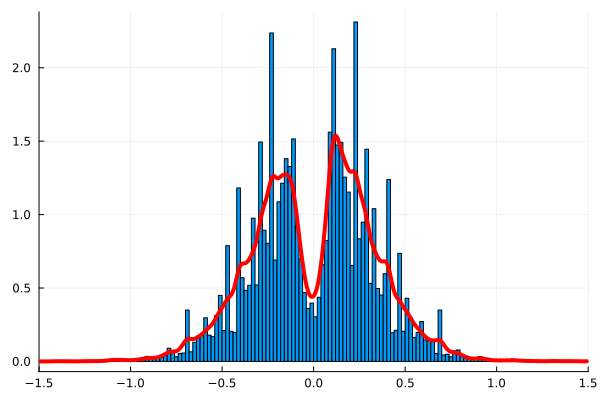

In [18]:
# plot the histogram and fitted density of non-standardized changes

density = kde(raw_changes,bandwidth=0.035,kernel=Logistic)
histogram(raw_changes,xlim=[-1.5,1.5],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

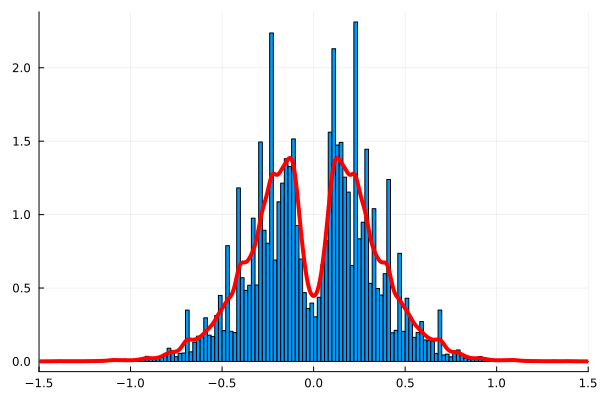

In [19]:
# plot the histogram and fitted symmetrized density of non-standardized changes

raw_changes_sym = vcat(-raw_changes[2:end],raw_changes[2:end])
density = kde(raw_changes_sym,bandwidth=0.035,kernel=Logistic)
histogram(raw_changes,xlim=[-1.5,1.5],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

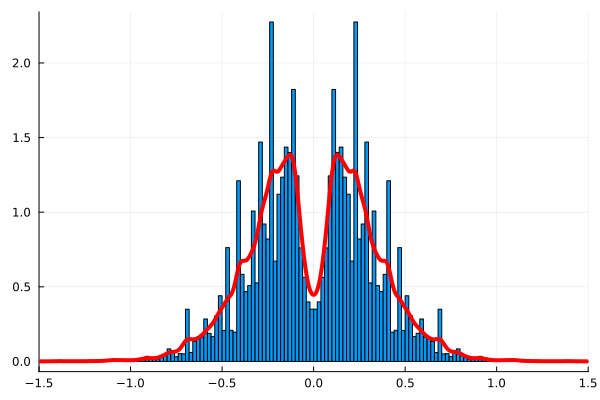

In [20]:
# plot the symmetrized histogram and fitted symmetrized density of non-standardized changes

kernel_den_raw = DataFrame(x = density.x, q = density.density)
CSV.write("kernel_den_raw.csv",kernel_den_raw)
histogram(raw_changes_sym,xlim=[-1.5,1.5],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

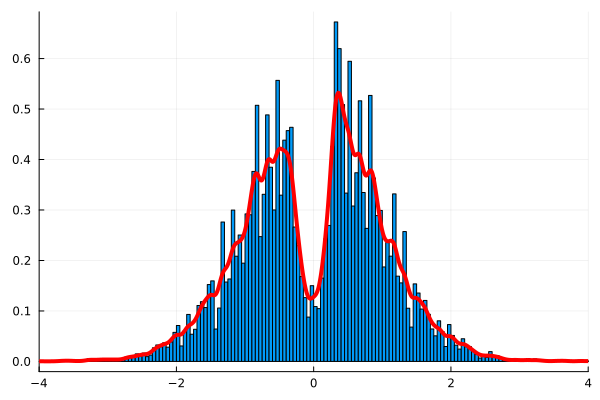

In [21]:
# plot the histogram and fitted density of standardized changes

density = kde(standardized_changes,bandwidth=0.08,kernel=Logistic)
kernel_den_raw = DataFrame(x = density.x, q = density.density)
histogram(standardized_changes,xlim=[-4,4],normed=true,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

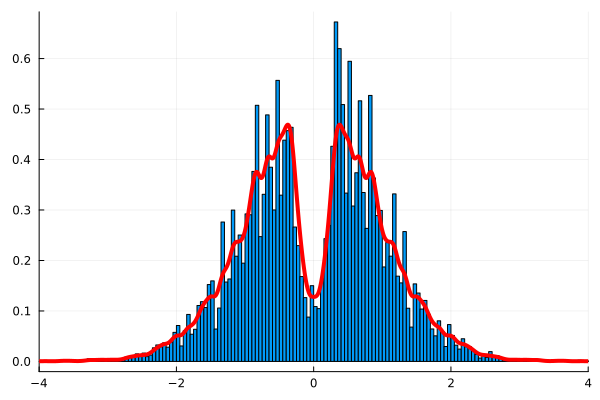

In [22]:
# plot the histogram and fitted symmetrized density of standardized changes

standardized_changes_sym = vcat(-standardized_changes[2:end],standardized_changes[2:end])
density = kde(standardized_changes_sym,bandwidth=0.08,kernel=Logistic)
histogram(standardized_changes,xlim=[-4,4],normed=true,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

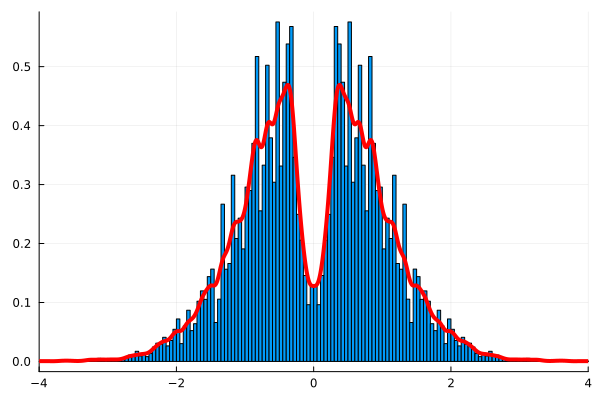

In [23]:
# plot the symmetrized histogram and fitted symmetrized density of standardized changes

kernel_den_sta = DataFrame(x = density.x, q = density.density)
CSV.write("kernel_den_sta.csv",kernel_den_sta)
histogram(standardized_changes_sym,xlim=[-4,4],normed=true,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

In [24]:
# produce the table with the statistics
# part of this table is table 1 in the paper
# another part goes to the apendix

stat_string = DataFrame(category_id = Int64.(statistics.category_id))
for name in names(statistics)
    stat_string[!,name] = map(x->string(round(x;digits=3)),statistics[:,name])
end
stat_string[!, :number_price_changes] = Int64.(round.(statistics[!, :number_price_changes]))
stat_string[!, :number_of_products] = Int64.(round.(statistics[!, :number_of_products]))
stat_string[!, :category_id] = Int64.(round.(statistics[!, :category_id]))
CSV.write("categories_big_table.csv",stat_string);